# Test model viz

Can we specify a model visualization that lacks the difficulties of bending matplotlib to the task? Let's see how writing SVG with [svgwrite](https://github.com/mozman/svgwrite) ([docs here](https://svgwrite.readthedocs.io/en/master/index.html)) works out. If this works, our end goal would be full svg representation of the model which would incidently give us a means of tieing into ipython's [rich display systems](https://ipython.readthedocs.io/en/stable/config/integrating.html).

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import svgwrite

showsvg = lambda svg: SVG(svg.tostring())

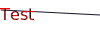

In [63]:
svg = svgwrite.Drawing(profile="Tiny", size=("100", "50"))
svg.add(svg.line((1, 10), (200, 20), stroke=svgwrite.rgb(10, 10, 16, '%')))
test_text = svg.add(svg.text('Test', insert=(0, 20), fill='red'))
showsvg(svg)

What does that look like raw?

In [64]:
svg.tostring()

'<svg baseProfile="tiny" height="50" version="1.2" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><line stroke="rgb(10%,10%,16%)" x1="1" x2="200" y1="10" y2="20" /><text fill="red" x="0" y="20">Test</text></svg>'

And is it modifiable? 

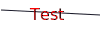

In [65]:
test_text.attribs['x'] = 30
showsvg(svg)

What I get from this is that attibutes of svg components can be natively modified and re-rendered or displayed. So you can either re-generate the svg at each time point or alter it on a timestep by timestep basis. 

What do we want a model visualization to look like with this approach? Let's look at a mockup:

![Mockup](./model_mockup.png)

What we have are:
 - in black: a series of tracts
 - in blue: actin filaments
 - in green: $\alpha$-actinin links to adjacent tracts, currently not showing x-dir offset
 - in gray: anchors that are fixing actin filament ends
 
In order to have each of those pieces I need to be able to return svg representations of each of the objects of interest, group them, translate the group to a tract location in the document coordinates, and then apply per-tract masking in order to not have things overflow from each tract into its neighbors.

Let's explore the ability to create, add to, style, and transform groups. 

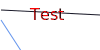

In [66]:
group = svg.add(svg.g(id='test_group', stroke='cornflowerblue'))
group.add(svg.line((1,20), (40,80)))
showsvg(svg)

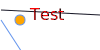

In [67]:
group.add(svg.circle((20,20), 5, fill='orange'))
showsvg(svg)

Can we define a style and then reuse it? This would make it easier to implement a common look across elements by type.

In [69]:
dwg = svgwrite.Drawing(profile="Full", size=("100", "50"))
dwg.add(dwg.style("stroke:cornflowerblue; fill:white"))
dwg.tostring()

'<svg baseProfile="full" height="50" version="1.1" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><style type="text/css"><![CDATA[stroke:cornflowerblue; fill:white]]></style></svg>'

That isn't what we want to do. It is an embedding of a CSS style within an element and requires the `Full` svg profile in order to implement it (as it counts as a scripting call. I think that `defs` might be what we want to use based on [this](https://developer.mozilla.org/en-US/docs/Web/SVG/Element/defs).

<svg baseProfile="tiny" height="50" version="1.2" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs><line id="actin" x1="0" x2="0" y1="0" y2="0" /></defs><line id="actin" x1="0" x2="0" y1="0" y2="0" /></svg>


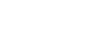

In [70]:
dwg = svgwrite.Drawing(profile="Tiny", size=("100", "50"))
dwg.add(dwg.defs.add(dwg.line(id='actin')))#, stroke=svgwrite.rgb(10, 10, 16, '%'))))
dwg.use('actin', (1,10))#, (100,40))
#svg.add(svg.line((1, 10), (200, 20), stroke=svgwrite.rgb(10, 10, 16, '%')))
#test_text = svg.add(svg.text('Test', insert=(0, 20), fill='red'))
print(dwg.tostring())
showsvg(dwg)

Turns out `def`s let us set the insertion location, width, and height of the element but not attributes like start and end. This means that we can't vary line length through the use of defs and thus won't find them to be of much use. 

We could explore the use of paths, but I think we're getting into some more complicated territory. The best route forward might be to let each line have a representation at `y=0` and translate them to the proper (random) y location. Let's see how the translation interface (added as mixins to each class so uniform?) work. 

<svg baseProfile="tiny" height="50" version="1.2" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><line stroke="rgb(10%,10%,16%)" transform="translate(0,20)" x1="0" x2="100" y1="0" y2="0" /></svg>


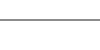

In [71]:
dwg = svgwrite.Drawing(profile="Tiny", size=("100", "50"))
l = dwg.add(dwg.line((0,0),(100,0), stroke=svgwrite.rgb(10, 10, 16, '%')))
l.translate(0, 20)
print(dwg.tostring())
showsvg(dwg)

Ok, I like that more. I'm going to try two things now:
1. See how painful it is to switch back to CSS styling for a centralized control.  
2. Create a group for a tract, populate it, and translate the whole thing.

In [72]:
# Trying CSS styling again, since it looks like what we want to do in the longer term
CSS_STYLES = """
    .background { fill: oldlace; }
    .actin { stroke: cornflowerblue; stroke-width: 2px; }
    .actinin { stroke: lightgreen; stroke-width: 1px; }
    .tract { stroke: darkslategray; fill: gainsboro; stroke-width: 3px; }
"""

<svg baseProfile="full" class="background" height="120" version="1.1" width="200" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs><style type="text/css"><![CDATA[
    .background { fill: oldlace; }
    .actin { stroke: cornflowerblue; stroke-width: 2px; }
    .actinin { stroke: lightgreen; stroke-width: 1px; }
    .tract { stroke: darkslategray; fill: gainsboro; stroke-width: 3px; }
]]></style></defs><g transform="translate(0,5)"><rect class="tract" height="50" width="200" x="0" y="0" /></g><g transform="translate(0,60)"><rect class="tract" height="50" width="200" x="0" y="0" /></g></svg>


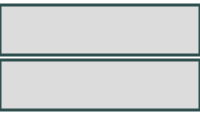

In [77]:
dwg = svgwrite.Drawing(size=("200", "120"), class_='background')
dwg.defs.add(dwg.style(CSS_STYLES)) # lets us use class defs from CSS_STYLES

def gen_tract(dwg, y):
    tract = dwg.add(dwg.g())
    tract.add(dwg.rect(size=(dwg.attribs['width'], 50), class_='tract'))
    tract.translate(0,y)
    return tract

tracts = [gen_tract(dwg, i) for i in (5, 60)]
#tract.add(dwg.line((0,0),(100,0)))

### LEFT OFF HERE, WE HAVE RELATIVE TRACT SPACE COORDINATES (GRAPH EACH AS IF THEY ARE AT 0,0 AND THEN TRANSLATE. NEED TO DEFINE SINGLE TRACT

#l = dwg.add(dwg.line((0,0),(100,0), stroke=svgwrite.rgb(10, 10, 16, '%')))
#l.translate(0, 20)
print(dwg.tostring())
showsvg(dwg)

In [16]:
dwg.attribs['width']

'200'

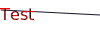

In [13]:
%%svg
<svg baseProfile="tiny" height="50" version="1.2" width="100" 
xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink">
        <defs />
        <line stroke="rgb(10%,10%,16%)" x1="1" x2="200" y1="10" y2="20" />
        <text fill="red" x="0" y="20">Test</text>
</svg>

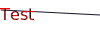

In [14]:
%%svg
<svg baseProfile="tiny" height="50" version="1.2" width="100" 
xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink">
        <defs>
            <line id="actin" stroke="rgb(10%,10%,16%)" />
        </defs>
        <use xlink:href="#actin" x1="1" x2="200" y1="10" y2="20"/>
        <text fill="red" x="0" y="20">Test</text>
</svg>

# Before going further, check that this is interpretable by others...
Let's see if we can create generator functions for actin, α-actinin, anchors, and a tract.

There are a bunch of ways to implement the bounds that we are interested in observing from above. The most fool-proof is to create a [clipping path](https://github.com/mozman/svgwrite/blob/master/examples/ltattrie/tiling_part_1.py) that we assign a url to and pass to each created object to obey. Further, we can do the "intuitive" thing and group each of the components of a tract [as here](https://github.com/mozman/svgwrite/blob/5ce5ed51c094223043644bed7fd89e8d7ccdc91f/examples/checkerboard.py) and then clip the group. As a helpful future pointer, [named colors](https://www.december.com/html/spec/colorsvg.html) are easy to specify.

In [53]:
def tractspace_svg(svg):
    """Make a set of tract boxes for each tract in a tractspace"""
    pass
    
def tract_svg(svg, ybounds):
    """Create a box for a tract"""
    pass
    
def actin_svg(svg, bounds, tract_svg_object, y=None):
    """Create a line for an actin fil within a tract"""
    pass #not really implemented, realized I need to get y bounds from passed tract
    xmin, xmax = bounds
    if y is None:
        y = np.random.rand() * float(svg.attribs['height'])
    line = svg.add(svg.line((xmin, y), (xmax, y), stroke='dodgerblue'))
    return line

def actinin_svg(svg, xloc, tract_svg_object, actin_svg_object=None):
    """Create a green line from an actin to the nearest tract edge at a given x loc"""
    pass